In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect, and_, or_

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
Base.prepare(engine, reflect=True)
# reflect the tables

In [7]:
# We can view all of the classes that automap found
for c in Base.classes:
    print(c.__table__)

measurement
station


In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(bind=engine)

# Exploratory Climate Analysis

In [10]:
# data exploration
import datetime
from sqlalchemy.types import Date, Numeric, Integer


print('Available Measurement columns')
insp = inspect(engine)
print([d['name'] for d in insp.get_columns('measurement')])

# dates are stored as strings thus we need ot confirm all are in the same format. 
assert session.query(Measurement).filter(~Measurement.date.like('____-__-__')).count() == 0

# Verify there are only floats in observations
# This will throw value error if there is a non float value
for v in pd.read_sql(session.query(Measurement.tobs).group_by(Measurement.tobs).statement, engine)['tobs'].values: 
    float(v)
    
# it looks like there are several 'None' values in the precipitation columns
assert session.query(Measurement).filter(Measurement.prcp == None).count() > 0
# this values should be ignored in queries that deal only with precipitation
no_null_prcp = session.query(Measurement).filter(Measurement.prcp != None)
for v in pd.read_sql(no_null_prcp.group_by(Measurement.prcp).statement, engine)['prcp'].values:
    float(v)
    

Available Measurement columns
['id', 'station', 'date', 'prcp', 'tobs']


Text(0, 0.5, 'Inches')

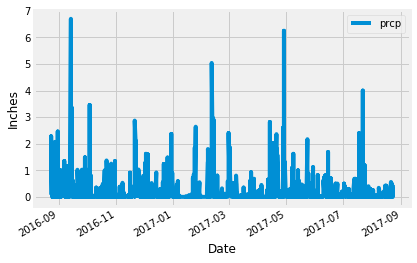

In [11]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from the last data point in the database
# SQLite does not support dates thus casting is not an option. Since all values in date column are in the same date string 
# format, string comparison can be used. 
last_date = session.query(func.max(Measurement.date)).first()[0]
twelve_months_ago = datetime.datetime.strptime(last_date, '%Y-%m-%d') - pd.DateOffset(months=12)
twelve_months_ago_str = twelve_months_ago.strftime('%Y-%m-%d')

# Perform a query to retrieve the data and precipitation scores
not_null_measurements_last_twelve_months = session.query(Measurement.date, Measurement.prcp) \
    .filter(and_(Measurement.date > twelve_months_ago_str, Measurement.prcp != None))

# Save the query results as a Pandas DataFrame and set the index to the date column
df = pd.read_sql(not_null_measurements_last_twelve_months.statement, engine)
df['date'] = df['date'].apply(lambda s: datetime.datetime.strptime(s, '%Y-%m-%d'))
df = df.set_index('date')

# Sort the dataframe by date
sorted = df.sort_values('date')
# Use Pandas Plotting with Matplotlib to plot the data
ax = sorted.plot()
ax.set_xlabel('Date')
ax.set_ylabel('Inches')

In [12]:
# Use Pandas to calcualte the summary statistics for the precipitation data
sorted.describe()

prcp
count  2015.000000
mean      0.176462
std       0.460288
min       0.000000
25%       0.000000
50%       0.020000
75%       0.130000
max       6.700000

In [13]:
# Design a query to show how many stations are available in this dataset?
session.query(Station).count()

9

In [14]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.

# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?

sql = session.query(
    Measurement.station, 
    func.count(Measurement.id).label('measurement count'),
    func.min(Measurement.tobs).label('minimum temp'),
    func.max(Measurement.tobs).label('maximum temp'),
    func.avg(Measurement.tobs).label('average temp')) \
    .group_by(Measurement.station) \
    .order_by(func.count(Measurement.id).desc()) \
    .statement
pd.read_sql(sql, engine)


station  measurement count  minimum temp  maximum temp  average temp
0  USC00519281               2772          54.0          85.0     71.663781
1  USC00519397               2724          56.0          87.0     74.553231
2  USC00513117               2709          59.0          85.0     72.689184
3  USC00519523               2669          56.0          85.0     74.543649
4  USC00516128               2612          58.0          84.0     70.915008
5  USC00514830               2202          58.0          85.0     74.873297
6  USC00511918               1979          53.0          87.0     71.615968
7  USC00517948               1372          58.0          87.0     74.684402
8  USC00518838                511          58.0          83.0     72.724070

Text(0, 0.5, 'Temperature')

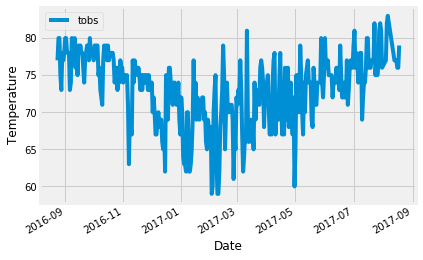

In [15]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
measurements_last_twelve_months = session.query(Measurement.date, Measurement.tobs) \
    .filter(Measurement.date > twelve_months_ago_str)

sql = measurements_last_twelve_months.filter(Measurement.station == 'USC00519281').statement
df = pd.read_sql(sql, engine)
df['date'] = df['date'].apply(lambda s: datetime.datetime.strptime(s, '%Y-%m-%d'))
df = df.set_index('date')
ax = df.plot()
ax.set_xlabel('Date')
ax.set_ylabel('Temperature')


## Bonus Challenge Assignment

In [173]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [174]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.


In [175]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [ ]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
